<h1>Proyecto Final PLN</h1>
<h3>José Rodrigo Calles</h1>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np 
import nltk
from os import getcwd
import re
import unidecode
import xmltodict
import seaborn as sns
from sklearn import model_selection
from sklearn. feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier        
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


<h2>Lectura y preparación de los datos</h2>
<p>Abrimos los datos de entramiento y prueba pasando los archivos de xml a un diccionario</p>

In [2]:
with open('TASS2019_country_MX_train.xml') as fd:
    train = xmltodict.parse(fd.read())
    
with open('TASS2019_country_MX_dev.xml') as fd:
    test = xmltodict.parse(fd.read())

<p>Ya que salió un diccionario anidado, se utilizará la función 'flatten_dict' para convertirlo en una diccionario más sencillo. Esto facilitará la conversión de los datos a un data frame.</p>

In [3]:
def flatten_dict(dd, separator='_', prefix=''):
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }

In [4]:
flattened_doc_train = [flatten_dict(x) for x in train['tweets']['tweet']]
flattened_doc_test = [flatten_dict(x) for x in test['tweets']['tweet']]

<p>Se convirtieron los cojuntos de entramiento y prueba en data frames y después se concatenaron para poder dividir los datos de una mejor manera.</p>

In [5]:
df_train = pd.DataFrame(flattened_doc_train)
df_test = pd.DataFrame(flattened_doc_test)

In [6]:
frames = [df_train, df_test]
  
df = pd.concat(frames)

In [7]:
df.shape

(1499, 6)

In [10]:
df.head(10)

,tweetid,user,content,date,lang,sentiment_polarity_value
0,767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,NEU
1,772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,N
2,771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,P
3,771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,P
4,774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,N
5,773634625126043649,153941006,- Yo Mamá por qué nunca en dejaste disfrutar m...,Wed Sep 07 21:30:42 +0000 2016,es,N
6,774269209933066240,439622331,Eso de no poder dormir y despertar en la madru...,Fri Sep 09 15:32:19 +0000 2016,es,N
7,773082982286434304,124661577,- ¿Qué me estás arrimando? - Algo que te gusta...,Tue Sep 06 08:58:40 +0000 2016,es,N
8,769234024128585728,143502210,"Lejos, lejos, muy lejos...manejar hasta acá es...",Fri Aug 26 18:04:17 +0000 2016,es,NEU
9,769394693184581636,3021645558,"Y fue como ""¿Viste cuantos akatsukis salen?"", ...",Sat Aug 27 04:42:44 +0000 2016,es,N


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1499 entries, 0 to 509
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweetid                   1499 non-null   object
 1   user                      1499 non-null   object
 2   content                   1499 non-null   object
 3   date                      1499 non-null   object
 4   lang                      1499 non-null   object
 5   sentiment_polarity_value  1499 non-null   object
dtypes: object(6)
memory usage: 82.0+ KB


<h2>Limpieza de datos</h2>
<p>Se quitaron los datos con valor "NONE" del conjunto de dato, lo que ocacionó una reducción de 1499 fila a 896</p> 

In [25]:
#Se quitan los valores 'NONE' de los valores de sentimientos
df = df_train[df_train.sentiment_polarity_value != 'NONE']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 0 to 988
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweetid                   896 non-null    object
 1   user                      896 non-null    object
 2   content                   896 non-null    object
 3   date                      896 non-null    object
 4   lang                      896 non-null    object
 5   sentiment_polarity_value  896 non-null    object
dtypes: object(6)
memory usage: 49.0+ KB


In [26]:
#Hacemos un mapeo de los valores de sentimientos para que sean números: Positivo=1, Negativo=0, 
#Neutro=2
df.sentiment_polarity_value = df.sentiment_polarity_value.map({ 'P' : 1.0, 'N' : 0, 
                                                                          'NEU':2.0})


/Users/rodrigocalles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
df.head(10)

,tweetid,user,content,date,lang,sentiment_polarity_value
0,767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,2.0
1,772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,0.0
2,771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,1.0
3,771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,1.0
4,774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,0.0
5,773634625126043649,153941006,- Yo Mamá por qué nunca en dejaste disfrutar m...,Wed Sep 07 21:30:42 +0000 2016,es,0.0
6,774269209933066240,439622331,Eso de no poder dormir y despertar en la madru...,Fri Sep 09 15:32:19 +0000 2016,es,0.0
7,773082982286434304,124661577,- ¿Qué me estás arrimando? - Algo que te gusta...,Tue Sep 06 08:58:40 +0000 2016,es,0.0
8,769234024128585728,143502210,"Lejos, lejos, muy lejos...manejar hasta acá es...",Fri Aug 26 18:04:17 +0000 2016,es,2.0
9,769394693184581636,3021645558,"Y fue como ""¿Viste cuantos akatsukis salen?"", ...",Sat Aug 27 04:42:44 +0000 2016,es,0.0


<p>Se utlizó la función LimpaTexto para limpiar el texto de los tweets. Se cambió todo el texto a minúsculas, se quitó el símbolo "@" en las menciones y se quitarón los híper textos. Después se agregó una columna con el texto limpio.</p>

In [27]:
def limpiaTexto(text):
    # Cambia texto a minusculas
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #quita las @
    text = re.sub(r'#', '', text) #quita los # 
    remplaza_por_espacios_re = re.compile('[\n(){}\[\]\|,;\"\“\”\‘\’\'\«\»!¡?¿_]')
    text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','',text) #quita los híper textoss
    return text

df['tweets_limpios'] = df['content'].apply(limpiaTexto)

/var/folders/7c/0_dkztsn29vd_ngxhnqbg74h0000gn/T/ipykernel_40832/654620952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets_limpios'] = df['content'].apply(limpiaTexto)


In [12]:
df.head(10)

,tweetid,user,content,date,lang,sentiment_polarity_value,tweets_limpios
0,767817507897872385,71463624,— ¿Nivel de inglés? — Alto. — Traduzca juguete...,Mon Aug 22 20:15:33 +0000 2016,es,2.0,— ¿nivel de inglés? — alto. — traduzca juguete...
1,772486813948575745,572924309,Si soy de área 4 y con suerte pase mate IV y m...,Sun Sep 04 17:29:43 +0000 2016,es,0.0,si soy de área 4 y con suerte pase mate iv y m...
2,771871884451295233,158142748,Sabían que su after fav Teatro G. fue construi...,Sat Sep 03 00:46:12 +0000 2016,es,1.0,sabían que su after fav teatro g. fue construi...
3,771947976302456832,132254421,Y hoy por primera vez me salí con el permiso d...,Sat Sep 03 05:48:34 +0000 2016,es,1.0,y hoy por primera vez me salí con el permiso d...
4,774741645484896256,105530236,"¿Para qué hacen coraje con Ambriz?, al final n...",Sat Sep 10 22:49:36 +0000 2016,es,0.0,"¿para qué hacen coraje con ambriz?, al final n..."
5,773634625126043649,153941006,- Yo Mamá por qué nunca en dejaste disfrutar m...,Wed Sep 07 21:30:42 +0000 2016,es,0.0,- yo mamá por qué nunca en dejaste disfrutar m...
6,774269209933066240,439622331,Eso de no poder dormir y despertar en la madru...,Fri Sep 09 15:32:19 +0000 2016,es,0.0,eso de no poder dormir y despertar en la madru...
7,773082982286434304,124661577,- ¿Qué me estás arrimando? - Algo que te gusta...,Tue Sep 06 08:58:40 +0000 2016,es,0.0,- ¿qué me estás arrimando? - algo que te gusta...
8,769234024128585728,143502210,"Lejos, lejos, muy lejos...manejar hasta acá es...",Fri Aug 26 18:04:17 +0000 2016,es,2.0,"lejos, lejos, muy hasta acá esta padre! algo ..."
9,769394693184581636,3021645558,"Y fue como ""¿Viste cuantos akatsukis salen?"", ...",Sat Aug 27 04:42:44 +0000 2016,es,0.0,"y fue como ""¿viste cuantos akatsukis salen?"", ..."


<p>Se definó la "X" que se usará (los tweets limpios) y la "Y". También se vectorizó los datos de entrada utilizando la función de 'countvectorizer' para que el modelo funcione bien.</p>

In [28]:
X = df['tweets_limpios']
countvectorizer = CountVectorizer()
X=countvectorizer.fit_transform(X)
y = df['sentiment_polarity_value']

In [14]:
X.shape, y.shape

((896, 3702), (896,))

<p>Con la función 'train_test_split', se dividieron los datos en entrenamiento y prueba, con un 70% para entrenamiento y el 30% restante para pruebas</p>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [136]:
X_train.shape, X_test.shape

((627, 3702), (269, 3702))

In [137]:
X_train

<627x3702 sparse matrix of type '<class 'numpy.int64'>'
	with 9209 stored elements in Compressed Sparse Row format>

<h2>Random Forest</h2>
<p>Obtenemos nuestro diccionario de parámetros para obtener los mejores híper parámetros y se entrenó utilizando la función 'GridSearchCV'<p>

In [162]:
param_grid1 = {'n_estimators': [60, 70, 80, 90, 100, 200, 400, 300, 600], 'max_depth': [10,50,100,150], 
              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2,5,10],
              'bootstrap': [True, False]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),param_grid1,cv=cv,n_jobs=-1,verbose=2)
grid_rf.fit(X_train,y_train.values.ravel())

Fitting 30 folds for each of 648 candidates, totalling 19440 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] E

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, mi

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_sampl

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_sa

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_s

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_sa

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=5, min_sam

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, 

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_s

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_sampl

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_sampl

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_sa

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_s

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_s

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_sampl

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10,

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=5, min_s

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10,

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=

[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, 

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_l

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_l

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_l

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=100, min_samples_

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_lea

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, min_samp

[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, min_samples_

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_le

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=60; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_sample

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=150, min_samp

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=150, min_samp

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=150, min_samples_lea

[CV] END bootstrap=True, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.5s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=True, max_depth=150, min_samples_lea

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min


[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_lea

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_sample

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samp

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=300; total time=   1.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=5, min_samples_split=5, n_estimators=600; total time=   2.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, 

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2,

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, 

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, min_samples_

[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=10, min_samples_split=10, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, min_samples_lea

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END bootstrap=False, max_depth=50, min_sample

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   4.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   4.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   4.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   4.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=70; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2,

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, 

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=2, n_estimators=600; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5,

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   1.9s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samp

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, min_samp

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   1.9s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=5, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, min_samp

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_s

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_sam

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, min_samples

[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=50, min_

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=70; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=80; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_lea

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.1s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   3.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.0s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.8s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.0s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.4s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_sampl

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_sam

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, min_sam

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=80; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=90; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_lea

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_s

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, mi

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_sam

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, max_depth=100,

[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=80; total time=   0.2s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=10, min_samples_split=5, n_estimators=90; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, min_sam

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.6s[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.0s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   4.5s
[CV] END bootstrap=False, max_depth=150, min_sam

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_sa

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=70; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=80; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=90; total time=   0.6s
[CV] END bootstrap=False, max_depth=150, min_sam

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   2.1s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   4.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   4.5s
[CV] END bootstrap=False, max_depth=150, min_sam


[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   2.9s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   3.0s
[CV] END bootstrap=False, max_depth=150

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=150,

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_lea

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.5s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=   4.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, 100, 150],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [60, 70, 80, 90, 100, 200, 400, 300,
                                          600]},
             verbose=2)

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=70; total time=   0.3s
[CV] END bootstrap=False, max_depth=150, min_sam

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=False, max_depth=150,

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.1s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   2.1s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=10, min_samples_split=5, n_estimators=70; total time=   0.2s
[CV] END bootstrap=False, max_depth=150, min_

[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.8s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.6s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   3.0s
[CV] END bootstrap=False, max_depth=150, min_samples_leaf=5, min_samples_split=10, n_estimators=600; total time=   2.7s
[CV] END bootstrap=False, max_depth=150,

<p>Obtuvimos los mejores híper parámetros y posteriormente se hiceron las predicciones y se obtuvo la precisión del modelo<p>

In [163]:
grid_rf.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 70}

In [164]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)
print("The accuracy Random Forest is : ", accuracy_score(y_test.values.ravel(), y_pred.round())*100, "%")

The accuracy Random Forest is :  63.19702602230484 %


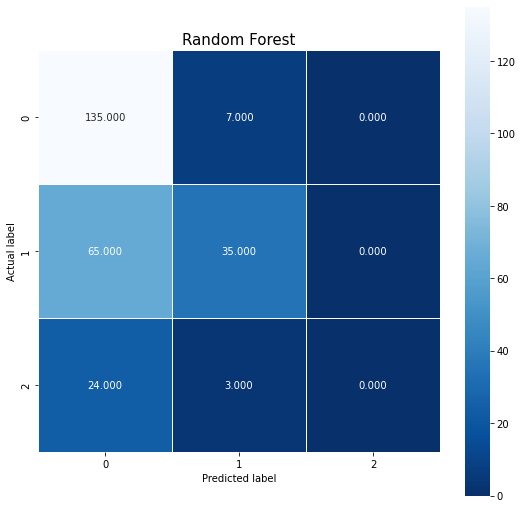

In [165]:

cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest', size = 15);


<h2> Máquinas de Vector de Soporte</h2>


In [151]:
param_grid2 = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ['rbf', 'poly', 'sigmoid']}

grid_svc = GridSearchCV(SVC(),param_grid2, refit=True, verbose=3)
grid_svc.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.579 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.579 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.584 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.576 total time=   0.1s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.635 total time=   0.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.611 total time=   0.1s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.592 total time=   0.1s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.608 total time=   0.1s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.624 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.540 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

[CV 4/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.584 total time=   0.0s
[CV 5/5] END ....C=1, gamma=0.1, kernel=sigmoid;, score=0.632 total time=   0.0s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.579 total time=   0.1s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.603 total time=   0.1s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.592 total time=   0.1s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.576 total time=   0.1s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.592 total time=   0.1s
[CV 1/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.579 total time=   0.1s
[CV 2/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.579 total time=   0.1s
[CV 3/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.584 total time=   0.1s
[CV 4/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.576 total time=   0.1s
[CV 5/5] END ......C=1, gamma=0.01, kernel=poly;, score=0.576 total time=   0.1s
[CV 1/5] END ...C=1, gamma=0

[CV 4/5] END .C=10, gamma=0.001, kernel=sigmoid;, score=0.576 total time=   0.1s
[CV 5/5] END .C=10, gamma=0.001, kernel=sigmoid;, score=0.584 total time=   0.1s
[CV 1/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.579 total time=   0.0s
[CV 3/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.584 total time=   0.0s
[CV 4/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.576 total time=   0.0s
[CV 5/5] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.576 total time=   0.0s
[CV 1/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.579 total time=   0.0s
[CV 2/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.579 total time=   0.0s
[CV 3/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.584 total time=   0.0s
[CV 4/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.576 total time=   0.0s
[CV 5/5] END ...C=10, gamma=0.0001, kernel=poly;, score=0.576 total time=   0.0s
[CV 1/5] END C=10, gamma=0.0

[CV 3/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.616 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.488 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.640 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.627 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.672 total time=   0.1s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.608 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.656 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.635 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.611 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.592 total time=   0.1s
[CV 4/5] END ....C=1000, gamma=0.1, kernel=poly;, score=0.608 total time=   0.1s
[CV 5/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=3)

In [152]:
grid_svc.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}

In [153]:
svc = grid_svc.best_estimator_
pred2 = svc.predict(X_test)
print("The accuracy of SVC: ", accuracy_score(y_test.values.ravel(), pred2.round())*100, "%")
#con tdif 68.401

The accuracy of SVC:  65.4275092936803 %


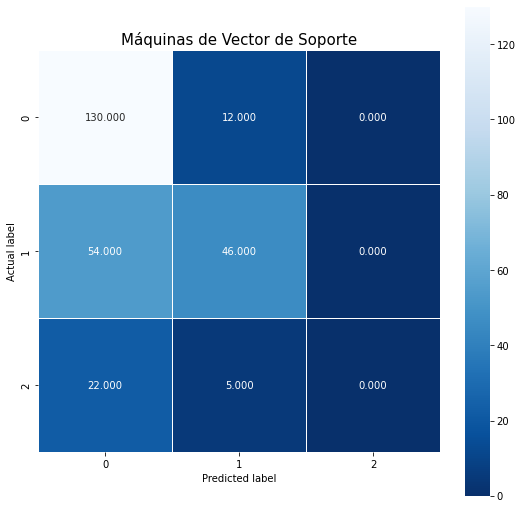

In [154]:

cm = metrics.confusion_matrix(y_test, pred2)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Máquinas de Vector de Soporte', size = 15);

<h1>Regresión Logística</h1>

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid_param = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_RegLog = GridSearchCV(LogisticRegression(max_iter=200),cv=cv, param_grid=grid_param, n_jobs=-1, scoring='accuracy',
                           error_score=0, verbose=3)
grid_RegLog.fit(X, y)


Fitting 30 folds for each of 15 candidates, totalling 450 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             error_score=0, estimator=LogisticRegression(max_iter=200),
             n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy', verbose=3)

In [31]:
grid_RegLog.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [32]:
mod_RegLog = grid_RegLog.best_estimator_
pred4 = mod_RegLog.predict(X_test)
print("The accuracy of Log Reg: ", accuracy_score(y_test.values.ravel(), pred4.round())*100, "%")

The accuracy of Log Reg:  97.02602230483272 %


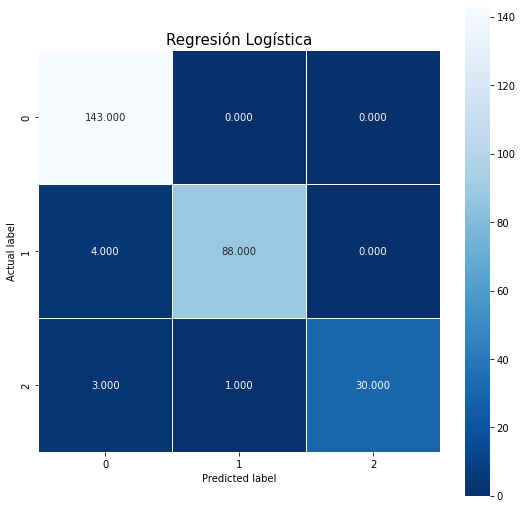

In [33]:

cm = metrics.confusion_matrix(y_test, pred4)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Regresión Logística', size = 15);